# Preliminary Time Series Analysis

The purpose of this notebook is to analyze the time series we want to model to confirm whether or not the chosen model (e.g., ARIMA) is appropriate. A lot of this code was inspired by posts from https://machinelearningmastery.com.

In [30]:
%load_ext autoreload
%autoreload 2

# Import local packages
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import market_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pprint import pprint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we need to load our time series data.

In [133]:
data = market_data.load_coingecko_market_data(['btc', 'eth'], series_name='Close Price', rel_path='../data')

Second, we need to check if the time series data is stationary.

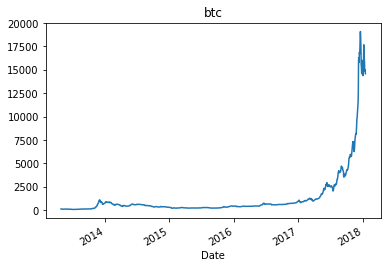

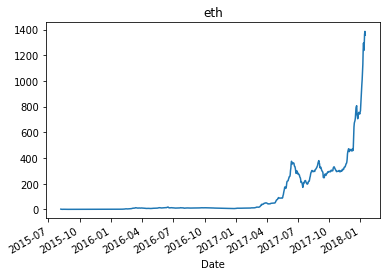

In [123]:
for ticker, ticker_data in data.items():
    ticker_data.plot()
    plt.title(ticker)
    plt.show()

Clearly there are some serious trends in our time series', therefore they are non-stationary. Let's try to change that by computing the first difference per time series.

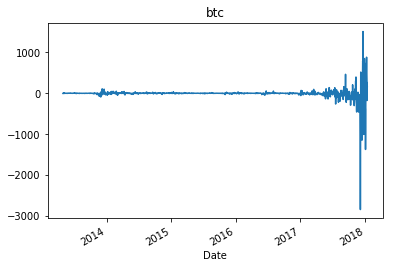

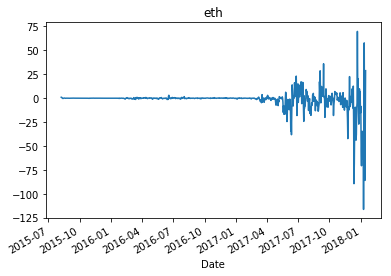

In [124]:
diff_data = {}
for ticker, ticker_data in data.items():
    diff_data[ticker] = ticker_data.shift(1) - ticker_data
    diff_data[ticker].plot()
    plt.title(ticker)
    plt.show()

Alright, it looks like taking the first difference gives our time series' stationarity. Let's check if the original time series' exhibit autocorrelation.

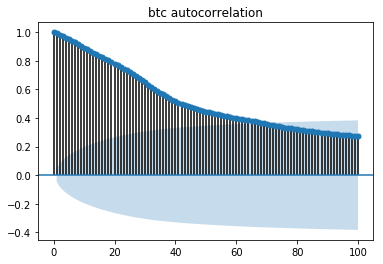

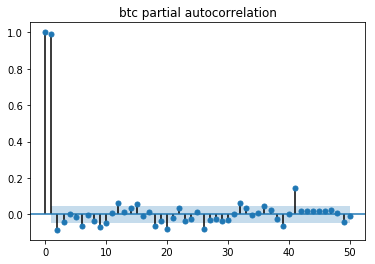

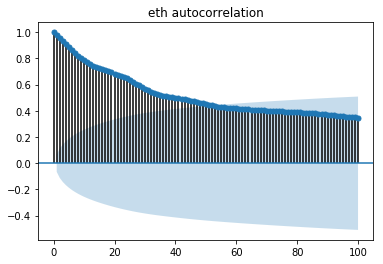

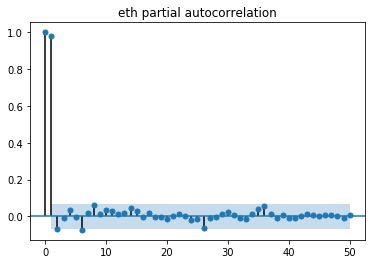

In [125]:
for ticker, ticker_data in data.items():
    plot_acf(ticker_data, lags=100, title='%s autocorrelation' % (ticker))
    plot_pacf(ticker_data, lags=50, title='%s partial autocorrelation' % (ticker))

Alright, looks like we have significant autocorrelation around 2 lags for each time series. This is based on the steep dropoffs seen in the PACF charts.

Now that we know our autocorrelation and difference factors (40, 1), let's try to fit an ARIMA model to our original time series' data.

FITTING ARIMA MODEL FOR BTC

Jarque-Bera statistic: 1435.848857
Residual mean: -0.008506
Residual std dev: 660.734294
Residual skewness: 1.748393
Residual kurtosis: 13.939963


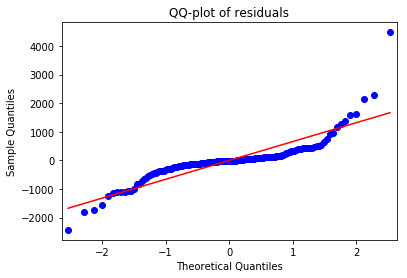

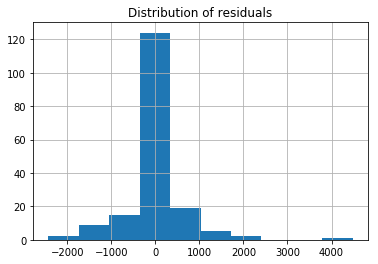

FITTING ARIMA MODEL FOR ETH

Jarque-Bera statistic: 576.458144
Residual mean: -0.000011
Residual std dev: 34.992574
Residual skewness: 0.969894
Residual kurtosis: 8.912791


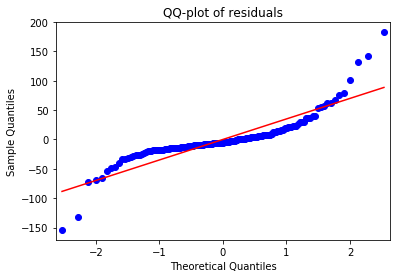

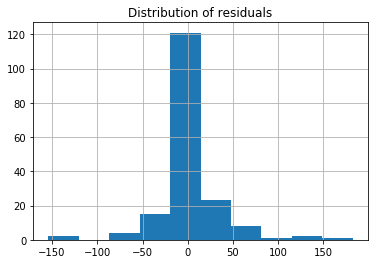

In [142]:
window = 180

for ticker, ticker_data in data.items():
    print('FITTING ARIMA MODEL FOR %s' % ticker.upper())
    print('')
    # Fit model on last year's worth of data
    model = ARIMA(ticker_data.iloc[-window:], order=(2, 1, 0))
    fit = model.fit(method='css', disp=0, solver='lbfgs')

    # Display useful information
    jb = jarque_bera(fit.resid)
    print('Jarque-Bera statistic: %f' % jb[0])
    print('Residual mean: %f' % fit.resid.mean())
    print('Residual std dev: %f' % fit.resid.std())
    print('Residual skewness: %f' % fit.resid.skew())
    print('Residual kurtosis: %f' % fit.resid.kurt())

    # QQ-plot of residuals
    probplot = sm.ProbPlot(fit.resid)
    probplot.qqplot(line='s')
    plt.title('QQ-plot of residuals')
    plt.show()

    # Residual distribution and statistics
    fit.resid.hist()
    plt.title('Distribution of residuals')
    plt.show()

It's imortant that our residuals show a normal distribution. In these cases, we are far from a standard normal distribution, but it's good that our residuals are almost centered at zero. As is normal with financial time series, we have noticable outliers in our distribution.